In [1]:
from __future__ import print_function, division
import os
import sys

# os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
fidx = 0

In [2]:
fishIdx = [("e", 2),  ("e", 5), ("c", 1),  ("c", 6),  ("enp", 1), ("enp", 5)]

#%%
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
import gc
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import seaborn as sb
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2
import resource
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import apex # https://github.com/NVIDIA/apex.git
from apex.amp import amp


import os, sys, datetime
import itertools
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

sys.path.insert(0,".")
from deepfish.helpers import get_frames_from_z, get_imaging_from_fish, gen_imaging, resize_volume, resize_batch, read_cnmf, no_overlap_idx, train_valid_test_split, train_test_split, pad_imaging

from deepfish.stats import sampleMSE
from deepfish.plot import interpret, plot_model_vs_real, makePredVideo, MSEbyDist, plot_embedding_over_time

from deepfish.data import ZebraFishData
# from deepfish.deep_kSVD import Deep_KSVD, train
from deepfish.deep_skip import DeepSkip, train
from deepfish.half_precision import network_to_half
from deepfish.volume import volume_mse

Model = DeepSkip

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
gen = False
# gen = True
cuda=True
# cnmf=True
cnmf=False
half=True
half=False
multi_gpu = True
num_workers = 16
prev_frames = 5
next_frames = 5
model_name = "180825_f01555_deep_skip_X=t-4:t_Y=t+1,t+5_epochs=15_Y_MSE=2.523E+01_Y_val_MSE=3.078E+01"

f = all_data[fishIdx[fidx][0]][fishIdx[fidx][1]]


frame_times = T.from_numpy(f.frame_st.mean(1).astype(np.float32))
shocks = T.FloatTensor(frame_times.shape).zero_()
shocks[np.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1

tail_movements = T.FloatTensor(frame_times.shape).zero_()
tail_movements[np.searchsorted(f.frame_et[:,-1],
    f.tail_movement_start_times,side="left")] = 1

fishpath = '/data2/Data/MPzfish/drn_hb/{}/{}_small.npz'.format(f.fishid, f.fishid)
imaging = np.load(fishpath)['fish']
imaging = pad_imaging(imaging, 128, 256)

In [4]:
tvt_split = train_test_split(2826, nchunks=20)
total_examples = sum([len(x) for x in tvt_split.values()])
print(["{}: {} ({:.2f}%)".format(k, len(v), 100*len(v)/total_examples) for k,v in tvt_split.items()])

train_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['train'], prev_frames,next_frames)

# valid_data = ZebraFishData(imaging,shocks,tail_movements,
#                         tvt_split['validation'], prev_frames,next_frames)

test_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['test'], prev_frames,next_frames)

total_data = ZebraFishData(imaging,shocks,tail_movements,
                        None, prev_frames,next_frames)

_, nZ, H, W = train_data[0][0]["brain"].shape

['test: 200 (8.14%)', 'train: 2257 (91.86%)', 'validation: 0 (0.00%)']


In [5]:
nEmbedding = 20
batch_size = 8
batch_size = 32

conv_model = Model(nZ,H,W,nEmbedding,prev_frames,next_frames,
                   tensor=T.cuda.FloatTensor)
if multi_gpu:
    conv_model = nn.DataParallel(conv_model)

In [7]:
conv_model.load_state_dict(T.load("trained_models/"+model_name+".pt"))

In [8]:
conv_model.cuda()
None

In [9]:
mses_train = sampleMSE(conv_model, train_data, 16)
mses_test = sampleMSE(conv_model, test_data, 16)

100%|██████████| 142/142 [01:30<00:00,  1.56it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.76it/s]Exception KeyError: KeyError(<weakref at 0x7f875d56d418; to 'tqdm' at 0x7f8a1469df90>,) in <object repr() failed> ignored

100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


In [50]:
a = mses_train["MSE(X_pred,Y_t+5)"]
b = mses_train["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_train["MSE(X_pred,X_t-4)"]
b = mses_train["MSE(Y_pred,X_t-4)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_train["MSE(X_pred,X_t)"]
b = mses_train["MSE(Y_pred,X_t)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_test["MSE(X_pred,Y_t+5)"]
b = mses_test["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b), a.mean()-b.mean())

a = mses_test["MSE(X_pred,X_t)"]
b = mses_test["MSE(Y_pred,X_t)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_test["MSE(X_pred,Y_t+1)"]
b = mses_test["MSE(Y_pred,Y_t+1)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

WilcoxonResult(statistic=11535.0, pvalue=0.0) Ttest_relResult(statistic=124.13125752153843, pvalue=0.0) 25460032.0
WilcoxonResult(statistic=63231.0, pvalue=0.0) Ttest_relResult(statistic=86.15726576706629, pvalue=0.0) 22609312.0
WilcoxonResult(statistic=57840.0, pvalue=0.0) Ttest_relResult(statistic=85.63058865066473, pvalue=0.0) 18250864.0
WilcoxonResult(statistic=1881.0, pvalue=2.1133559909343492e-23) Ttest_relResult(statistic=14.147304618780007, pvalue=6.652452222671146e-32) 5141088.0
WilcoxonResult(statistic=9545.0, pvalue=0.5377718053414828) Ttest_relResult(statistic=-2.167787457076357, pvalue=0.03136190897281804) -436432.0
WilcoxonResult(statistic=2047.0, pvalue=1.590775201043473e-22) Ttest_relResult(statistic=12.96024678826153, pvalue=2.982093370616059e-28) 3547168.0


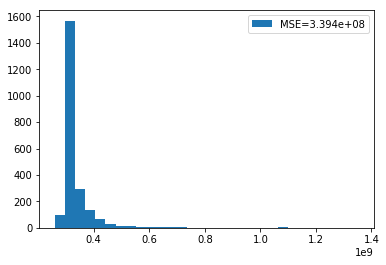

In [39]:
class FishMAData(Dataset):
    def __init__(self, imaging, ma=5, nfuture=1, index_map=None):
        data = imaging - imaging.mean(0)
        self.data = T.from_numpy(data)
        self.ma=ma
        self.nfuture=nfuture
        self.index_map=index_map
        
    def __len__(self):
        if self.index_map:
            return len(self.index_map)
        else:
            return self.data.shape[0]-self.ma-self.nfuture

    def __getitem__(self, i):
        if self.index_map:
            idx = self.index_map[i]
        else:
            idx = i
        return self.data[(idx-self.ma+1):(idx+1)].mean(0), self.data[idx+self.nfuture]

def MSE_MA(imaging, ma=5, nfuture=1, batch_size=256, index_map=None):
    mse = []
    with T.no_grad():
        data = FishMAData(imaging, ma, nfuture,index_map)
        dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X = X.cuda()
            Y = Y.cuda()
            mse.append(volume_mse(X, Y).cpu())

    return T.cat(mse).numpy()

mses_ma_train_5 = MSE_MA(imaging, 5, 5, 256, tvt_split['train'])
mses_ma_train_1 = MSE_MA(imaging, 5, 1, 256, tvt_split['train'])
mses_ma_test_5 = MSE_MA(imaging, 5, 5, 256, tvt_split['test'])
mses_ma_test_1 = MSE_MA(imaging, 5, 1, 256, tvt_split['test'])

plt.hist(mse,30)
plt.legend(["MSE={:.4g}".format(mse.mean())])

In [54]:
a = mses_ma_train_5
b = mses_train["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_ma_train_1
b = mses_train["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_ma_test_5
b = mses_test["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b), a.mean()-b.mean())

# a = mses_ma_test_1
# b = mses_test["MSE(Y_pred,X_t)"]
# print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())


WilcoxonResult(statistic=0.0, pvalue=0.0) Ttest_relResult(statistic=80.0985786745694, pvalue=0.0) 42282240.0
WilcoxonResult(statistic=1243608.0, pvalue=0.32510997528042307) Ttest_relResult(statistic=-5.322598507159876, pvalue=1.1241753305305507e-07) -5093856.0
WilcoxonResult(statistic=14.0, pvalue=1.7729943823825292e-34) Ttest_relResult(statistic=30.799112227408013, pvalue=1.2026673459816881e-77) 43701630.0


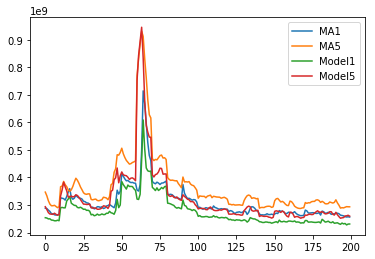

In [43]:
plt.plot(mses_ma_test_1)
plt.plot(mses_ma_test_5)
plt.plot(mses_test["MSE(Y_pred,Y_t+1)"])
plt.plot(mses_test["MSE(Y_pred,Y_t+5)"])
plt.legend(["MA1","MA5", "Model1", "Model5"])

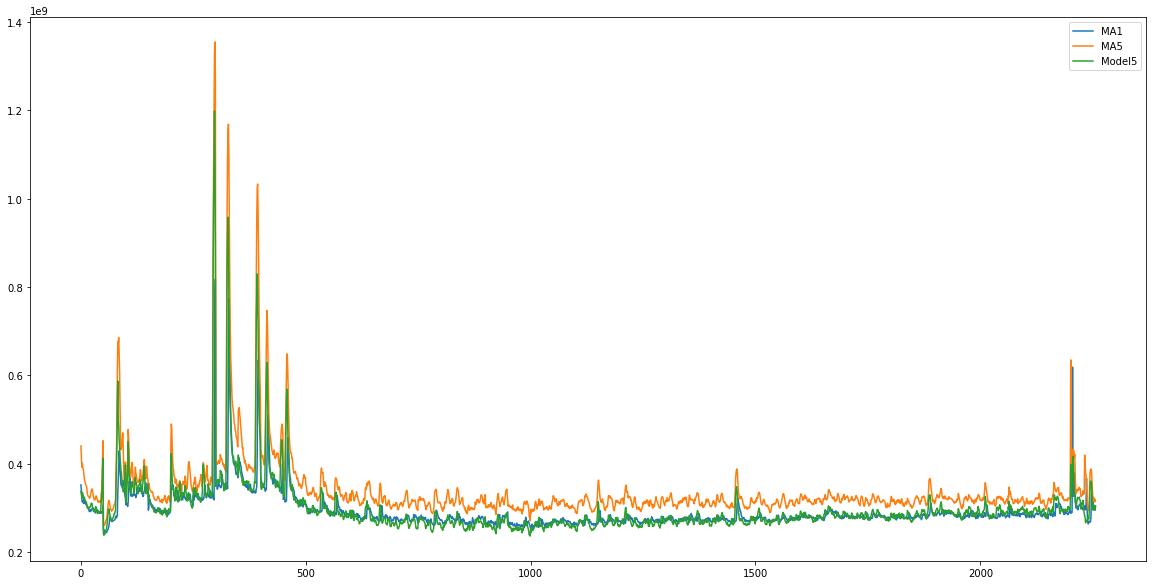

In [49]:
plt.figure(figsize=(20,10))
plt.plot(mses_ma_train_1)
plt.plot(mses_ma_train_5)
plt.plot(mses_train["MSE(Y_pred,Y_t+5)"])
plt.legend(["MA1","MA5", "Model5"])

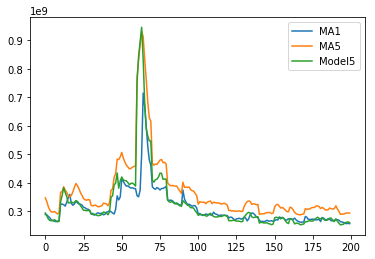

In [44]:
plt.plot(mses_ma_test_1)
plt.plot(mses_ma_test_5)
plt.plot(mses_test["MSE(Y_pred,Y_t+5)"])
plt.legend(["MA1","MA5", "Model5"])

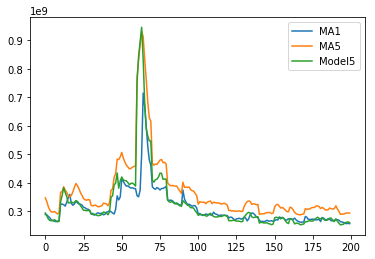

In [44]:
plt.plot(mses_ma_test_1)
plt.plot(mses_ma_test_5)
plt.plot(mses_test["MSE(Y_pred,Y_t+5)"])
plt.legend(["MA1","MA5", "Model5"])

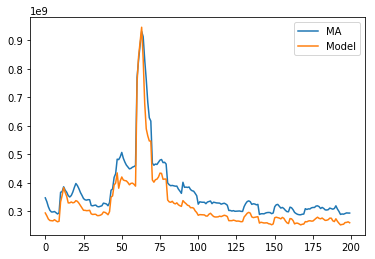

In [37]:
plt.plot(mses_ma_test)
plt.plot(mses_test["MSE(Y_pred,Y_t+5)"])
plt.legend(["MA", "Model"])

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


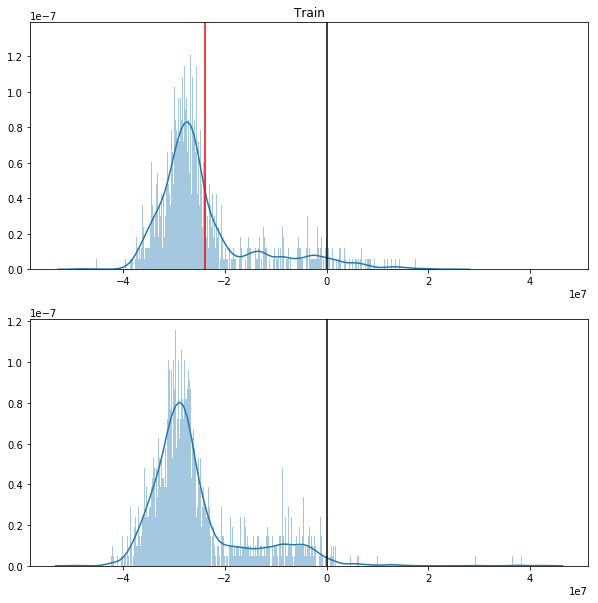

In [18]:
plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
mse_diff = mses_train["MSE(Y_pred,Y_t+1)"]-mses_train["MSE(X_pred,Y_t+1)"]
sb.distplot(mse_diff,1000)
plt.axvline(0,c='k')
plt.title("Train")
plt.axvline(mse_diff.mean(),c='r')
plt.subplot(2,1,2,sharex=ax)
sb.distplot(mses_train["MSE(Y_pred,Y_t+5)"] - \
            mses_train["MSE(X_pred,Y_t+5)"], 1000)
plt.axvline(0,c='k')
# plt.xlim(-0.5e8,.5e8)
plt.savefig("train_mse_diff.svg")

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


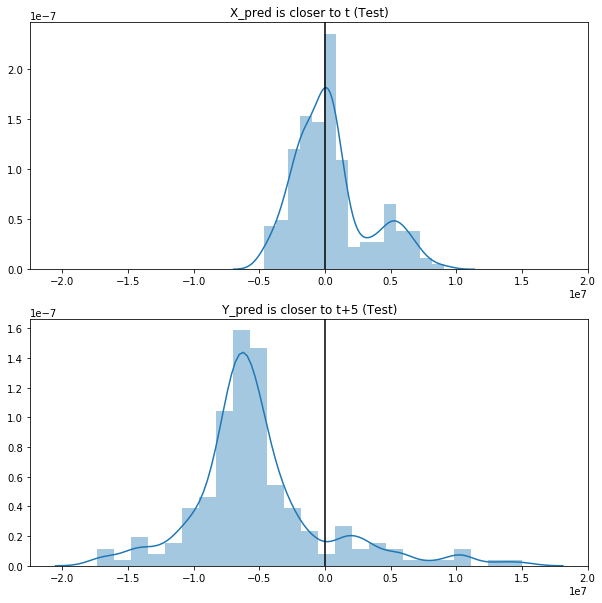

In [19]:
plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
sb.distplot(mses_test["MSE(Y_pred,X_t)"]-mses_test["MSE(X_pred,X_t)"])
plt.axvline(0,c='k')
plt.title("X_pred is closer to t (Test)")
plt.subplot(2,1,2,sharex=ax)
sb.distplot(mses_test["MSE(Y_pred,Y_t+5)"]-mses_test["MSE(X_pred,Y_t+5)"])
plt.title("Y_pred is closer to t+5 (Test)")
plt.axvline(0,c='k')
plt.savefig('test_mse_diff.svg')

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


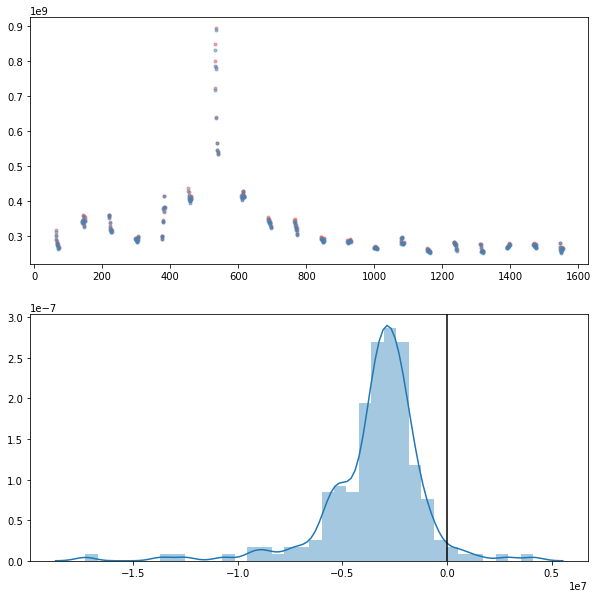

In [49]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(tvt_split["test"],mses_test["MSE(X_pred,Y_t+5)"],'.',c='indianred',alpha=0.5)
plt.plot(tvt_split["test"],mses_test["MSE(Y_pred,Y_t+5)"],'.',c='steelblue',alpha=0.5)
plt.subplot(2,1,2)
sb.distplot(mses_test["MSE(Y_pred,Y_t+5)"]-mses_test["MSE(X_pred,Y_t+5)"])
plt.axvline(0,c='k')

In [55]:
def plot_embedding_over_time(model,data, batch_size=64, num_workers=12):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    embeddings = []
    logvars = []
    model.eval()
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            embedding, logvar, _ = model.encode(X.cuda())
        embeddings.append(embedding.cpu().numpy())
        logvars.append(logvar.cpu().numpy())
    model.train()
    embeddings = np.vstack(embeddings)
    logvars = np.vstack(logvars)
    nEmbeddings = embeddings.shape[1]
    half = int(np.ceil(nEmbeddings / 2))
    
    plt.figure(figsize=(15,20))
    plt.subplot(4,1,1)
    plt.plot(embeddings[:,0:half])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(4,1,2)
    plt.plot(embeddings[:,half:])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    
    plt.subplot(4,1,3)
    plt.plot(logvars[:,0:half])
    plt.title("Logvars over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(4,1,4)
    plt.plot(logvars[:,half:])
    plt.title("Logvars over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    
    plt.tight_layout()
    return embeddings

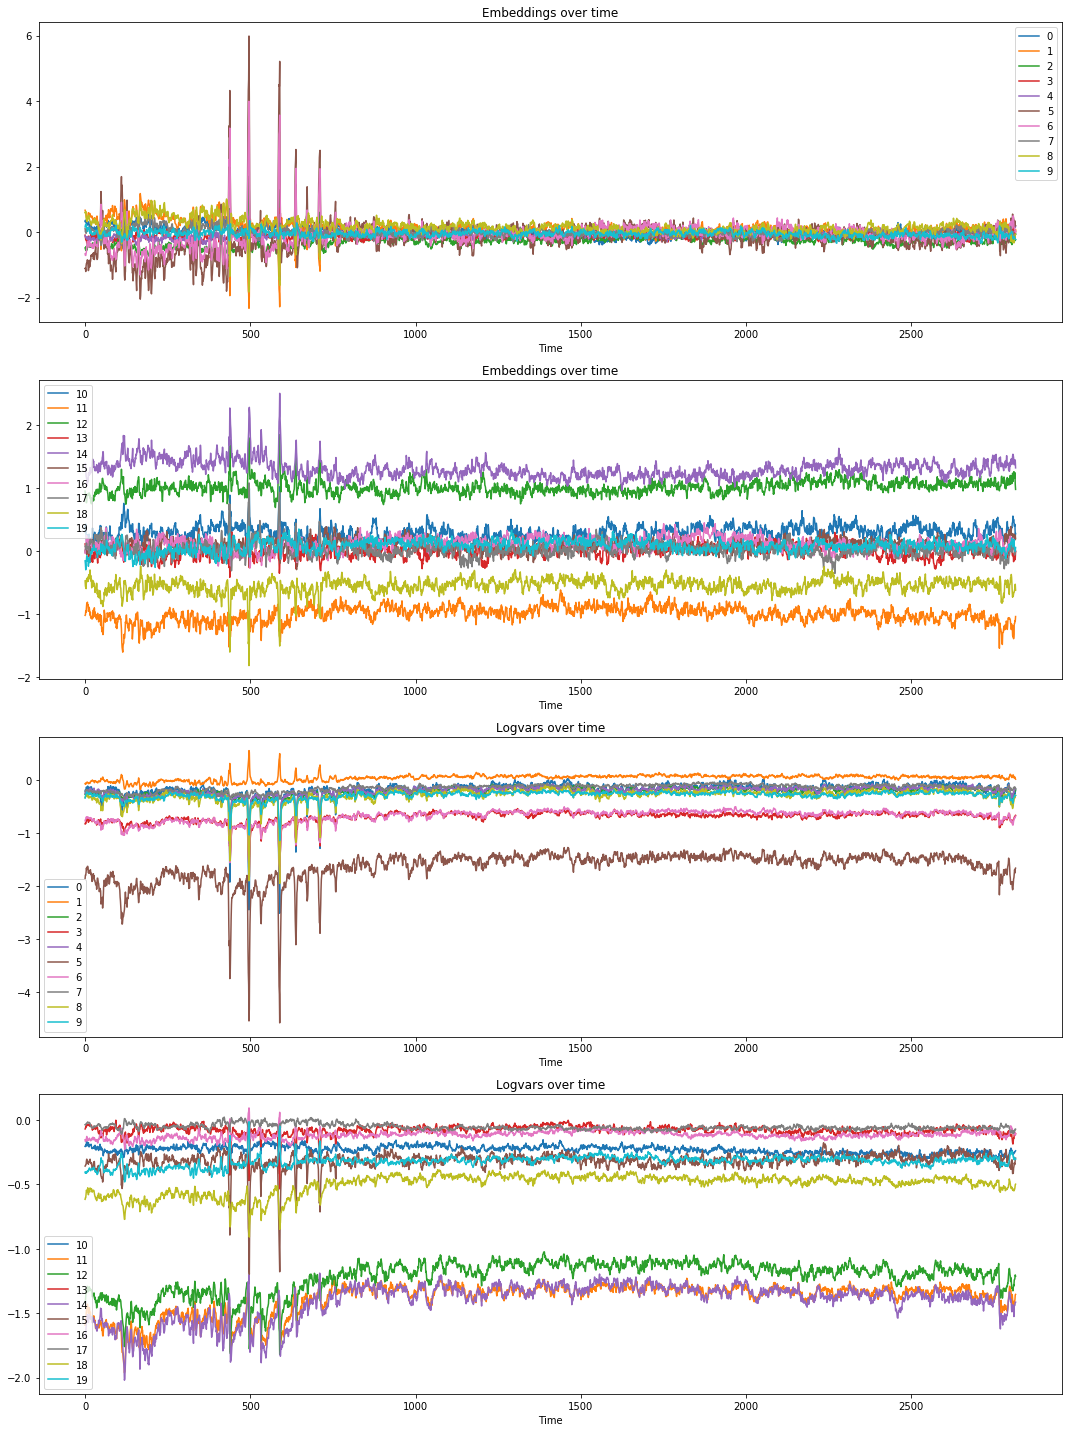

In [56]:
embeddings = plot_embedding_over_time(conv_model.module,total_data)

In [60]:
imaging[500].shape

(11, 128, 256)

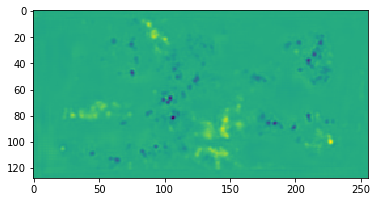

In [77]:
#for each latent
    #for a sampling of vols
#embedding = T.from_numpy(np.eye(nEmbedding)[i].astype(np.float32)).cuda()[None]
framenum = 500
halfembed = int(nEmbedding/2)
model = conv_model.module
with T.no_grad():
    fish_vol = T.from_numpy(imaging[None,framenum:(framenum+next_frames)]).cuda()
    encoded, logvar, skip = model.encode(fish_vol)
    latent_state_pred = T.from_numpy(np.zeros(halfembed, dtype=np.float32)).cuda()[None]
    #turn on latent being explored
    shock_state = T.cuda.FloatTensor(5).zero_()[None]
    pred_state = model.predict(latent_state_pred,shock_state)
    pred_vol = model.decode(pred_state,skip)[0]

    latent_state_prev = encoded[:,halfembed:]
    shock_state = T.cuda.FloatTensor(5).zero_()[None]
    prev_state = model.predictZero(latent_state_prev,shock_state)
    prev_vol = model.decode(prev_state,skip)[0]
plt.imshow(pred_vol[0,6]-prev_vol[0,6])

#WIP

# def get_gradient_from_embedding(model,frame,embedding,niters=20, lr=1e-3):
#     model.eval()
#     frame = frame.cuda()
#     frame.requires_grad = True
#     embedding_pred, _ = model.encode(frame)
#     print(embedding_pred.shape)
#     embedding_pred.backward(gradient=embedding)
#     model.train()
#     return frame.grad[0]

# def get_input_from_embedding(model,frame,embedding,niters=75, lr=1e-1, rand=False):
#     "Take an embedding vector, and use backprop to find the volume"
#     if rand:
#         prev_img = T.rand_like(frame[None], requires_grad=True).cuda()
#     else:
#         prev_img = frame[None].cuda()
#         prev_img.requires_grad = True
#     optimizer = T.optim.Adam([prev_img],lr=lr)
#     model.eval()
#     for i in range(niters):
#         embedding_pred, _ = model.encode(prev_img)
#         loss = F.mse_loss(embedding_pred,embedding[None]) #+ 1e-7*T.norm(prev_img,1)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
# #         print("iter {} loss: ".format(i), float(loss))
#     model.train()
#     return prev_img[0].detach().cpu().numpy()

def interpret(model,prev_vol, next_vol, nEmbedding):
    "Plot prev & next frame for each latent dimension"
    plt.figure(figsize=(10,40))
    
    embedding = T.from_numpy(np.zeros(nEmbedding).astype(np.float32)).cuda()[None]
#     shock = T.FloatTensor([0,1])[:,None,None].cuda()
    shock = T.cuda.FloatTensor(2,1,prev_frames).zero_()
    shock[0] = T.zeros(1,prev_frames)
    shock[1] = T.ones(1,prev_frames)
    with T.no_grad():
        prev_img = model.decode(embedding)[0][0] # ignore tail
        next_img = model.decode(model.predict(embedding,shock[0]))[0][0] # ignore tail
        next_img_shock = model.decode(model.predict(embedding,shock[1]))[0][0]
        
    plt.subplot(1+nEmbedding,4,1)
    plt.imshow(prev_img[6])
    plt.title("Prev (Zero Vector)")
    
    plt.subplot(1+nEmbedding,4,2)
    plt.imshow(next_img[6])
    plt.title("Next (Zero Vector)")
    
    plt.subplot(1+nEmbedding,4,3)
    plt.imshow(next_img[6] - prev_img[6])
    plt.title("Diff (Zero Vector)")
    
    plt.subplot(1+nEmbedding,4,4)
    plt.imshow(next_img_shock[6])
    plt.title("Next (Shock)")
    for i in range(nEmbedding):
        embedding = T.from_numpy(np.eye(nEmbedding)[i].astype(np.float32)).cuda()[None]
        with T.no_grad():
            prev_img = model.decode(embedding)[0][0]
            next_img = model.decode(model.predict(embedding,shock[0]))[0][0]
            next_img_shock = model.decode(model.predict(embedding,shock[0]))[0][0]
        plt.subplot(1+nEmbedding,4,i*4+5)
        plt.imshow(prev_img[6])
        plt.title("Prev (Dim {})".format(i))
        
        plt.subplot(1+nEmbedding,4,i*4+6)
        plt.imshow(next_img[6])
        plt.title("Next (Dim {})".format(i))
        
        plt.subplot(1+nEmbedding,4,i*4+7)
        plt.imshow(next_img[6]-prev_img[6])
        plt.title("Diff (Dim {})".format(i))
        
        plt.subplot(1+nEmbedding,4,i*4+8)
        plt.imshow(next_img_shock[6])
        plt.title("Next w/ shock (Dim {})".format(i))
    plt.tight_layout()

x, y = data[1000]
interpret(conv_model.module,x,y,nEmbedding)

In [64]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

import skvideo.io
def makePredVideo(model, data, batch_size=32, num_workers=12, name="test"):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(model_name + "_"+name+"_prediction.mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain'] for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain'] for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])
            
            frame[:H, :W] = y[0,6]
            frame[:H, W:(2*W)] = y[-1,6] - y[0,6]
            frame[:H, (2*W):] = y[-1,6]
            frame[H:, :W] = x_pred[6]
            frame[H:, W:(2*W)] = y_pred[6] - y[0,6].cuda() #x_pred[6]
            frame[H:, (2*W):] = y_pred[6]
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

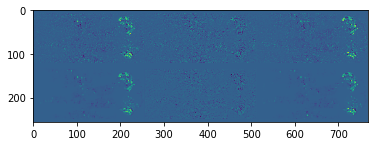

In [65]:
frame = makePredVideo(conv_model,train_data,name='train')

plt.imshow(frame)